In [11]:
from skimage import morphology
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage import measure
from skimage.filters import roberts, sobel
from sklearn.cluster import KMeans
from skimage.transform import resize
from skimage.segmentation import clear_border
from skimage.measure import label,regionprops, perimeter
from glob import glob
from scipy import ndimage as ndi
import matplotlib.pyplot as plt
import os
import sys
import numpy as np

In [67]:
subFolder="subset0"
working_path = os.path.join("/work/05268/junma7/maverick/luna16/",subFolder,subFolder+"_nodule/")
file_list=glob(working_path+"images_*.npy")


In [77]:
def segment_lung(img):
    #Standardize the pixel values
    mean = np.mean(img)
    std = np.std(img)
    img = img-mean
    img = img/std
    # Find the average pixel value near the lungs
    # to renormalize washed out images
    middle = img[100:400,100:400]
#     mean = np.mean(middle)  
#     max = np.max(img)
#     min = np.min(img)
    # To improve threshold finding, I'm moving the 
    # underflow and overflow on the pixel spectrum
#     img[img==max]=mean
#     img[img==min]=mean
    #
    # Using Kmeans to separate foreground (radio-opaque tissue)
    # and background (radio transparent tissue ie lungs)
    # Doing this only on the center of the image to avoid 
    # the non-tissue parts of the image as much as possible
    #
    kmeans = KMeans(n_clusters=2).fit(np.reshape(middle,[np.prod(middle.shape),1]))
    centers = sorted(kmeans.cluster_centers_.flatten())
    threshold = np.mean(centers)
    thresh_img = np.where(img<threshold,1.0,0.0)  # threshold the image
    #
    # I found an initial erosion helful for removing graininess from some of the regions
    # and then large dialation is used to make the lung region 
    # engulf the vessels and incursions into the lung cavity by 
    # radio opaque tissue
    #
    eroded = morphology.erosion(thresh_img,np.ones([2,2]))
    dilation = morphology.dilation(eroded,np.ones([5,5]))
    #
    #  Label each region and obtain the region properties
    #  The background region is removed by removing regions 
    #  with a bbox that is to large in either dimnsion
    #  Also, the lungs are generally far away from the top 
    #  and bottom of the image, so any regions that are too
    #  close to the top and bottom are removed
    #  This does not produce a perfect segmentation of the lungs
    #  from the image, but it is surprisingly good considering its
    #  simplicity. 
    #
    labels = measure.label(dilation)
    label_vals = np.unique(labels)
    regions = measure.regionprops(labels)
    good_labels = []
    for prop in regions:
        B = prop.bbox
        if B[2]-B[0]<475 and B[3]-B[1]<475 and B[0]>40 and B[2]<472:
            good_labels.append(prop.label)
    mask = np.ndarray([512,512],dtype=np.int8)
    mask[:] = 0
    #
    #  The mask here is the mask for the lungs--not the nodes
    #  After just the lungs are left, we do another large dilation
    #  in order to fill in and out the lung mask 
    #
    for N in good_labels:
        mask = mask + np.where(labels==N,1,0)
    mask = morphology.dilation(mask,np.ones([5,5])) # one last dilation
    return mask


on image /work/05268/junma7/maverick/luna16/subset0/subset0_nodule/images_0076_0348.npy
3


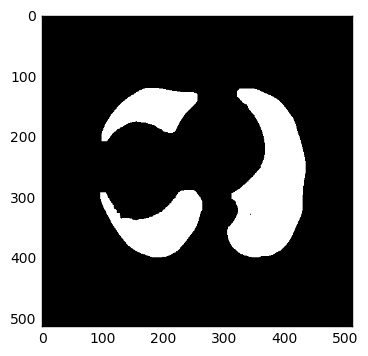

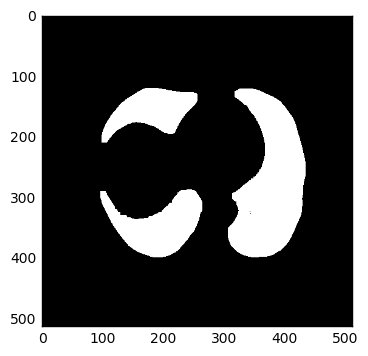

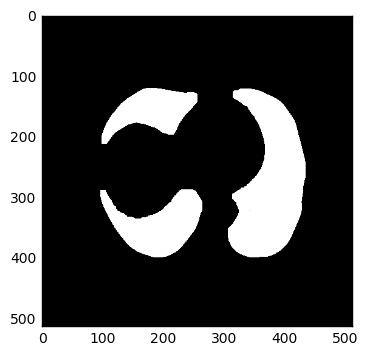

on image /work/05268/junma7/maverick/luna16/subset0/subset0_nodule/images_0040_0345.npy
3


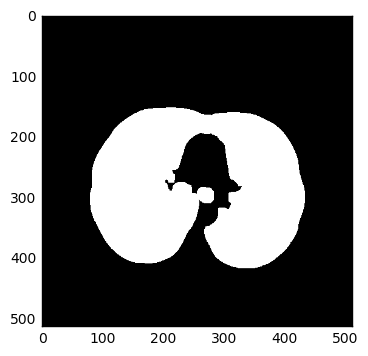

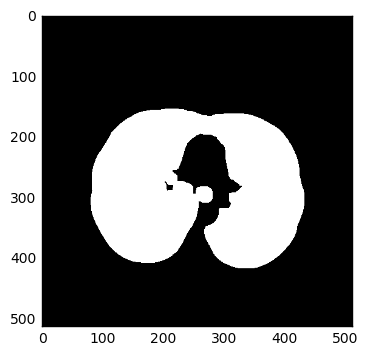

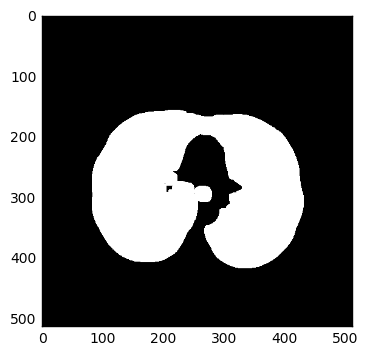

on image /work/05268/junma7/maverick/luna16/subset0/subset0_nodule/images_0058_0748.npy
3


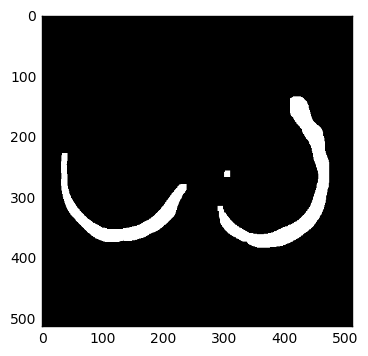

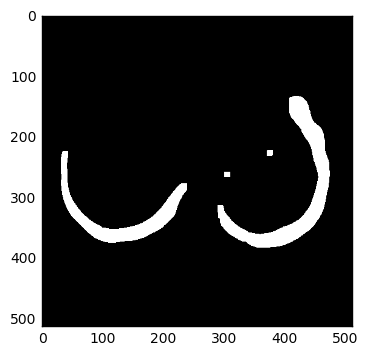

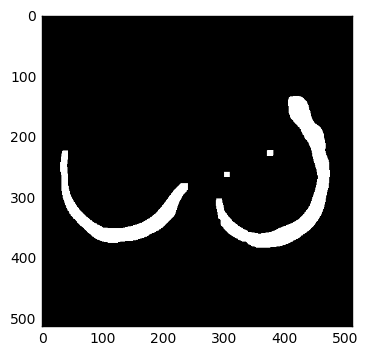

In [78]:
for img_file in file_list[2:5]:
    #segment_lung(img_file)
    imgs_to_process = np.load(img_file).astype(np.float64)
    print("on image "+ img_file)
    print(len(imgs_to_process))
    for i in range(len(imgs_to_process)):
        img = imgs_to_process[i]
        im=segment_lung(img)
        plt.imshow(im,cmap="gray")
        plt.show()
        imgs_to_process[i] = im
    np.save(img_file.replace("images","lungmask"),imgs_to_process)
#         print(im.shape)

In [64]:
def apply_mask(fname):
    print("working on file "+fname)
    imgs_to_process = np.load(fname.replace("lungmask","images"))
    masks = np.load(fname)
    node_masks = np.load(fname.replace("lungmask","masks"))
    for i in range(len(imgs_to_process)):
        mask = masks[i]
        node_mask = node_masks[i]
        img = imgs_to_process[i]
        new_size = [512,512]   # we're scaling back up to the original size of the image
        img= mask*img          # apply lung mask
        #
        # renormalizing the masked image (in the mask region)
        #
        new_mean = np.mean(img[mask>0])
        new_std = np.std(img[mask>0])
        #
        #  Pulling the background color up to the lower end
        #  of the pixel range for the lungs
        #
        old_min = np.min(img)       # background color
        img[img==old_min] = new_mean-1.2*new_std   # resetting backgound color
        img = img-new_mean
        img = img/new_std
        #make image bounding box  (min row, min col, max row, max col)
        labels = measure.label(mask)
        regions = measure.regionprops(labels)
        min_row = 512
        max_row = 0
        min_col = 512
        max_col = 0
        for prop in regions:
            B = prop.bbox
            if min_row > B[0]:
                min_row = B[0]
            if min_col > B[1]:
                min_col = B[1]
            if max_row < B[2]:
                max_row = B[2]
            if max_col < B[3]:
                max_col = B[3]
        width = max_col-min_col
        height = max_row - min_row
        if width > height:
            max_row=min_row+width
        else:
            max_col = min_col+height
        # 
        # cropping the image down to the bounding box for all regions
        # (there's probably an skimage command that can do this in one line)
        # 
        img = img[min_row:max_row,min_col:max_col]
        mask =  mask[min_row:max_row,min_col:max_col]
        if max_row-min_row <5 or max_col-min_col<5:  # skipping all images with no god regions
            pass
        else:
            # moving range to -1 to 1 to accomodate the resize function
            mean = np.mean(img)
            img = img - mean
            min = np.min(img)
            max = np.max(img)
            img = (img-mean)/(max-min)
            img[img<0.5]=0
            img[img>1]=1
            new_img = resize(img,[512,512])
            new_node_mask = resize(node_mask[min_row:max_row,min_col:max_col],[512,512])
            new_node_mask = (new_node_mask > 0.0).astype(np.float32)
            print(np.min(new_img),np.max(new_img))
            print(np.min(new_node_mask),np.max(new_node_mask))
            
            plt.imshow(new_img,cmap="gray")
            plt.show()
            plt.imshow(new_node_mask,cmap="gray")
            plt.show()
#             out_images.append(new_img)
#             out_nodemasks.append(new_node_mask)


/work/05268/junma7/maverick/luna16/subset0/subset0_nodule/lungmask_0076_0348.npy
working on file /work/05268/junma7/maverick/luna16/subset0/subset0_nodule/lungmask_0076_0348.npy
0.0 1.0
0.0 1.0


/home/05268/junma7/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/05268/junma7/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


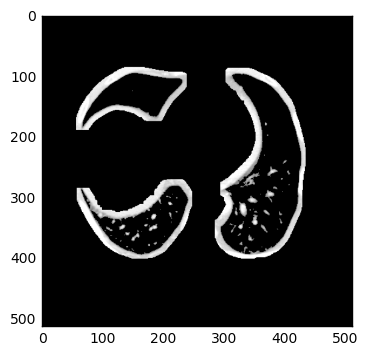

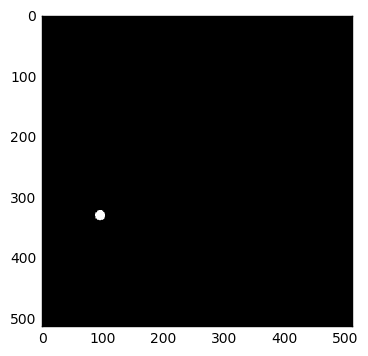

0.0 1.0
0.0 1.0


/home/05268/junma7/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/05268/junma7/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


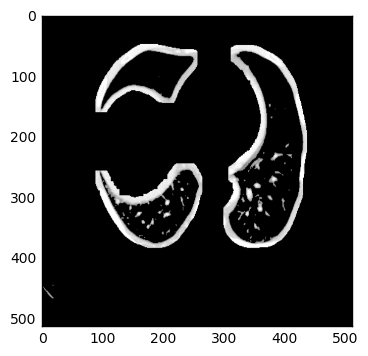

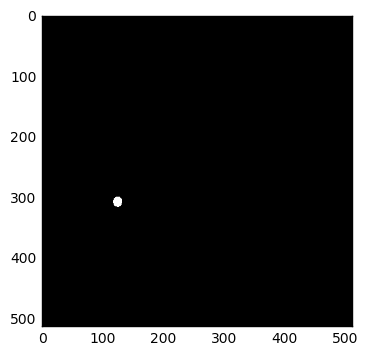

0.0 1.0
0.0 1.0


/home/05268/junma7/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/05268/junma7/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


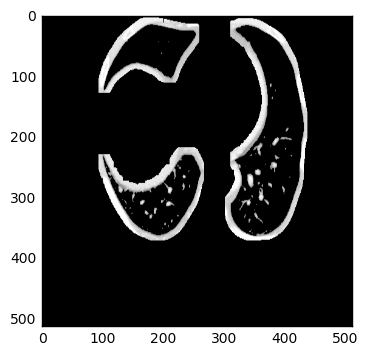

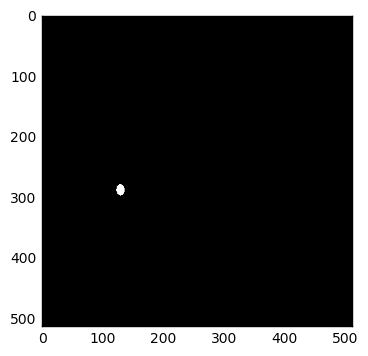

/work/05268/junma7/maverick/luna16/subset0/subset0_nodule/lungmask_0040_0345.npy
working on file /work/05268/junma7/maverick/luna16/subset0/subset0_nodule/lungmask_0040_0345.npy
0.0 0.954380798965
0.0 1.0


/home/05268/junma7/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/05268/junma7/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


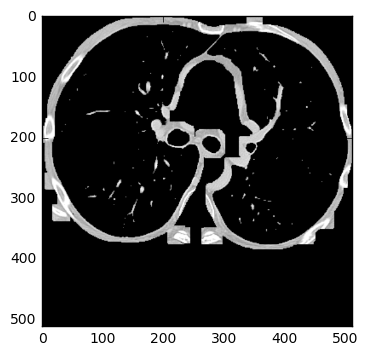

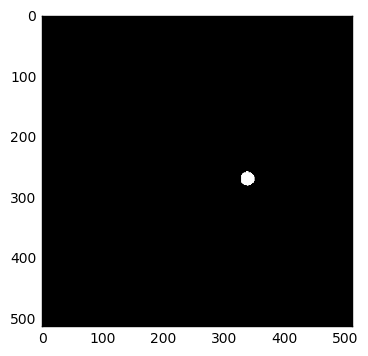

0.0 0.957110985668
0.0 1.0


/home/05268/junma7/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/05268/junma7/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


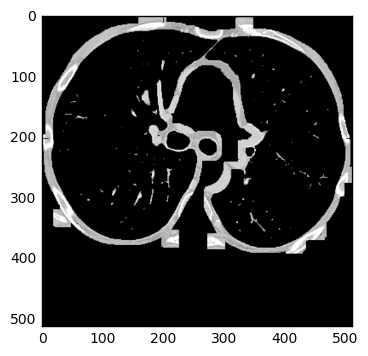

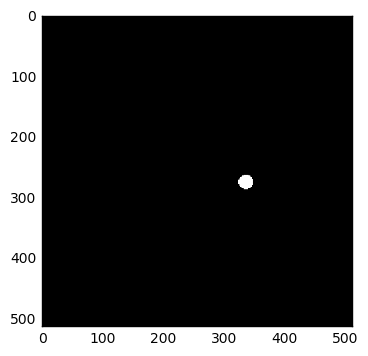

0.0 0.948648311322
0.0 1.0


/home/05268/junma7/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/05268/junma7/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


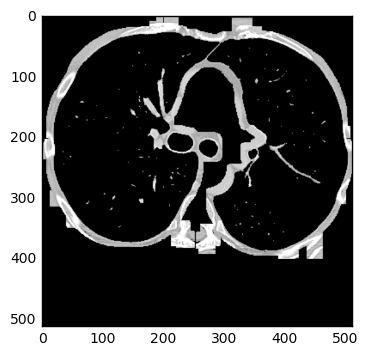

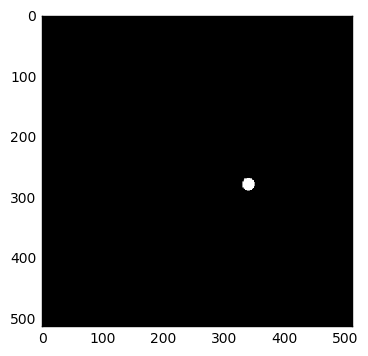

/work/05268/junma7/maverick/luna16/subset0/subset0_nodule/lungmask_0058_0748.npy
working on file /work/05268/junma7/maverick/luna16/subset0/subset0_nodule/lungmask_0058_0748.npy
0.0 1.0
0.0 1.0


/home/05268/junma7/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/05268/junma7/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


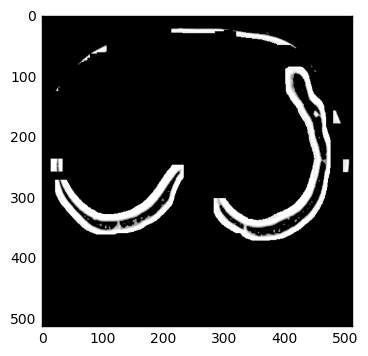

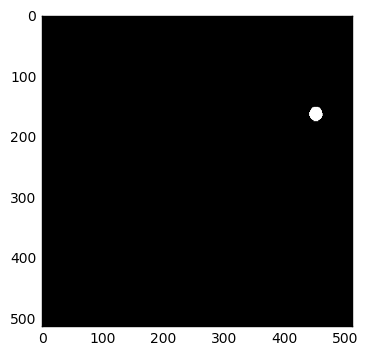

0.0 1.0
0.0 1.0


/home/05268/junma7/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/05268/junma7/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


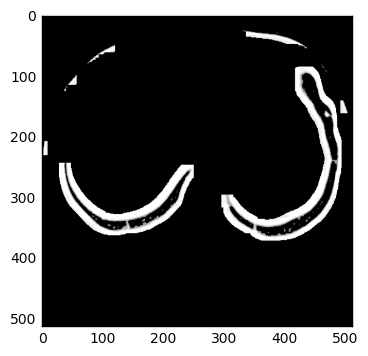

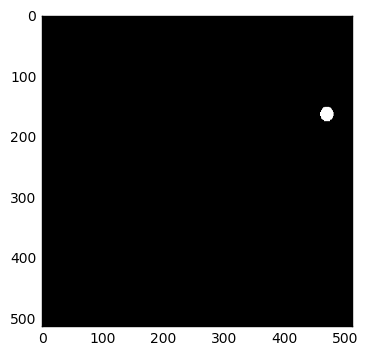

0.0 1.0
0.0 1.0


/home/05268/junma7/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/05268/junma7/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:84: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "


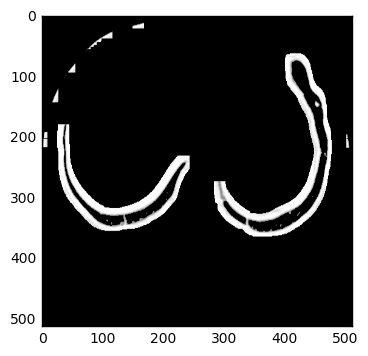

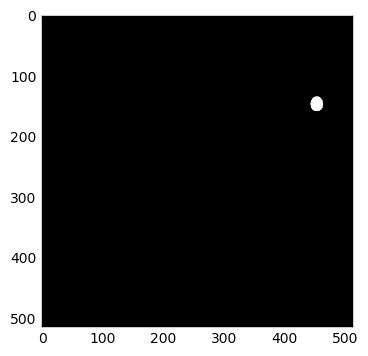

In [72]:
for fname in file_list[2:5]:
    fname=fname.replace("images","lungmask",)
    print(fname)
    apply_mask(fname)